In [226]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    "font.family": "serif",
    # "font.serif": ["Palatino"],
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 16,
    "font.size": 16,
    "axes.titlesize" : 16,
    # 'text.latex.preamble': r'\usepackage{amsfonts, amsmath,amssymb, mathrsfs}',
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14, 
    'figure.autolayout': True
    
}

import matplotlib.pyplot as plt 
import matplotlib
plt.rcParams.update(tex_fonts)

def generate_colormap_matrix(colormap_name, size):
    cmap = plt.get_cmap(colormap_name)
    norm = plt.Normalize(0, size - 1)

    colors = cmap(norm(range(size)))
    colors = np.reshape(colors, (size, 4))

    return colors

# Data Import

In [137]:
#### WESTERN EUROPE ####
df_list = []
df = pd.read_csv('Data FAO/FAOSTAT_AREA.csv')
df_list.append(df)
df = pd.read_csv('Data FAO/FAOSTAT_YIELD.csv')
df_list.append(df)
df = pd.read_csv('Data FAO/FAOSTAT_FERTILIZER.csv')
df_list.append(df)
df = pd.read_csv('Data FAO/FAOSTAT_PESTICIDE.csv')
df_list.append(df)
df_Price = pd.read_csv('Data FAO/commodity-price-index-cereal-crops-and-petroleum.csv')
df_Price = df_Price.rename(columns={"Wheat": "Value"})
condition = df_Price['Year'] >= 1961
df_Price = df_Price[condition]
df_list.append(df_Price)

# The Model

1. The farmer seeks to optimize the use of fertilizer ($F_{i,t}$) by maximizing a utility function ($\mathcal{U}_{i,t}$). The utility function is a combination of expected profits ($\hat{\mathcal{P}}_{i,t}$) and inertia ($\hat{\mathcal{I}}_{i,t}$), reflecting the farmer's resistance to change based on past experiences.

    $$
        F_{i,t} = \max_{F} \left\{\mathcal{U}_{i,t} \right\} = 
         \max_{F} \left\{\hat{\mathcal{P}}_{i,t}(F) + \kappa_{i,t} \hat{\mathcal{I}}_{i,t}(F)\right\} \quad \quad \kappa_{i,t}\in[0,1]
    $$

    Expected profits are computed using forecasted market prices ($\hat{p}_{i,t} = p_{i,t-1}$), production output ($L_{i,t} y(F)$), and various costs, including fertilizer cost ($p_{\text{F}} F$), operational costs ($p_{\text{O}}$), and non-operational costs ($p_{NO}$):

    $$
        \hat{\mathcal{P}}_{i,t}(F) = \hat{p}_{i,t}   - L_{i,t}( p_{\text{F}} F + p_{\text{O}}) - p_{\text{NO}}
    $$

    The inertia term ($\mathcal{I}_{i,t}$) penalizes deviations between expected revenues and previous revenues:

    $$
    \mathcal{I}_{i,t} =  \max\Big( \hat{p}_{i,t} L_{i,t} y(F) - p_{i,t-1}\alpha_{i,t-1}Y_{i,t-1}, 0 \Big)
    $$

    where $\alpha_{i,t} = \min \left(1, \frac{D_{i,t}}{Y_{i,t}} \right)$ represents the fraction of production sold to the market.

    The degree of inertia ($\kappa_{i,t}$) evolves over time based on the amount of goods sold in the market:

    $$
    \kappa_{i,t} = (1 - \omega) \kappa_{i,t-1} + \omega \lfloor \alpha_{i,t-1} \rfloor 
    $$

    This equation indicates that the inertia degree decreases when the business is performing well.

2. After determining the fertilizer level, the farmer proceeds with sowing and harvesting, resulting in production ($Y_{i,t}$). 

    $$
        Y_{i,t} = L_{i,t} y(F_{i,t})
    $$

    Prices ($p_{i,t}$) are set using a markup rule.

    $$
        C_{i,t} = L_{i,t} (p_F F_{i,t} + p_{\text{O}}) + p_{\text{NO}}
    $$

    $$
        p_{i,t} = (1 + \mu) \frac{C_{i,t}}{Y_{i,t}}
    $$

3. The representative household's demand is determined by a CES utility function, allowing for variations in sustainability and competition between farmers.

    $$
        \mathcal{U} =  \left( \sum_{i=1}^N x_i ^{r}\right)^{\frac{1}{r}} \quad \text{s.t.} \quad \sum_i p_{i,t} x_{i,t} = B
    $$

    $$
        D_{i,t} = \frac{p_i^{\sigma}}{\sum_j p_j^\sigma} D_t \quad \quad \sigma = \frac{1}{r -1}
    $$

    This approach enables variation from zero sustainability ($r \rightarrow 0$) to complete substitutability ($r \rightarrow 1$), affecting product competition. Observe that here we keep the total demand fixed instead of the total budget as it is commonly done.

4. The farmer computes profits considering the fraction of production sold ($\alpha_{i,t}$).

    $$
        w_{i,t+1} = w_{i,t} + {p}_{i,t} \alpha_{i,t} Y_{i,t} - C_{i,t} \quad \text{where} \quad \alpha_{i,t} =  \min \left\{1, \frac{D_{i,t}}{Y_{i,t}} \right\}
    $$

5. If a farmer's wealth becomes negative, bankruptcy occurs, and land is redistributed to active farmers based on relative wealth.

    $$
        \frac{\exp \left(\beta \frac{w_{i,t}}{\bar{w}_t} \right)}{\sum_k \exp\left(\beta \frac{w_{k,t}}{\bar{w}_t} \right)}
    $$


# Single Farmer

Here I want to show that it works with one single farmer. 

In [232]:
ymax = 9
Nr = 60
p0 = 500
p1 = 1000
p_F = 0.8

# Number of time steps in the simulation
num_steps = 100
size = 1000

gamma = 0.02
r = 0.3
beta = 10
theta = 0
delta = 0.05
sigma = 0.0
demand_growth = 0.02

In [237]:
def production(F, M):
    return ymax * (1 - np.exp(-1/Nr * (M * F))) * (1 + np.random.normal(0, 0.05, F.shape)) 

def F_optimal(previous_prod, M, p_M, fraction_sold, land_per_farmer, markup, risk_propensity, precision = 300):

    F_try = np.linspace(0, 300, precision)[:, np.newaxis]
    expected_production = land_per_farmer * production(F_try, M)
    expected_cost = (1 + markup) * land_per_farmer * ((p_F * F_try + p0) + p1)
    expected_revenues = p_M * expected_production 
    Profit_try = expected_revenues - expected_cost
    Risk_try = p_M * np.maximum(expected_production - fraction_sold * previous_prod, 0)
    Utility_try = Profit_try - (1 - risk_propensity) * Risk_try 
    max_P_indices = np.argmax(Utility_try, axis=0)  
    F_opt = F_try[max_P_indices, np.arange(F_try.shape[1])] 
    F_opt = F_opt 

    return F_opt

# Arrays to store values over the simulation
F_opt = np.zeros((num_steps, size))
risk_propensity = np.zeros((num_steps, size))
F = np.zeros((num_steps, size))
prod = np.zeros((num_steps, size))
markup = np.zeros((num_steps, size))
price = np.zeros((num_steps, size))
profit = np.zeros((num_steps, size))
revenues = np.zeros((num_steps, size))
costs = np.zeros((num_steps, size))
wealth = np.zeros((num_steps, size))
fraction_sold = np.zeros((num_steps, size))
land_per_farmer = np.zeros((num_steps, size))
active_farmer = np.zeros((num_steps, size), dtype=bool)
farmer_demand = np.zeros((num_steps, size))
MP = np.zeros((num_steps, size))
research_investment = np.zeros((num_steps, size))
demand = np.zeros((num_steps, size))
households_budget = np.zeros((num_steps, size))


# Initial values
land_per_farmer[0] = 1
F[0] = np.random.uniform(low = 30, high = 90, size = size)
MP[0] = np.random.uniform(low = 0.4, high=0.5, size=size)
risk_propensity[0] = 0.01
prod[0] = land_per_farmer[0] * production(F[0], MP[0])
markup[0] = 0.2
costs[0] = land_per_farmer[0] * (F[0] * p_F + p0) + p1
price[0] = (1 + markup[0]) * costs[0]/prod[0]
households_budget[0] = np.sum(land_per_farmer[0] * production(F[0], MP[0]) * price[0])
demand[0] = households_budget[0] * price[0]**(1/(r-1))/np.sum(price[0]**(r/(r-1))) 
fraction_sold[0] = 1/prod[0] * np.minimum(demand[0], prod[0])

revenues[0] = price[0] * fraction_sold[0] * prod[0]
profit[0] =  revenues[0] - costs[0]
wealth[0] = 1000
active_farmer[0] = True
research_investment[0] = 0


# Simulation loop
for t in range(1, num_steps):

    active_farmer[t] = wealth[t-1] > theta
    land_per_farmer[t] = land_per_farmer[t-1]
    MP[t] = MP[t-1]
    
    # Land market in case of bankruptcy
    prod_share = np.zeros(size)
    if np.any(wealth[t-1] < theta):
        prob = active_farmer[t] * np.exp(beta * wealth[t-1] * active_farmer[t-1] / wealth[t-1, active_farmer[t-1]].mean()) / np.sum(active_farmer[t] *np.exp(beta * wealth[t-1] * active_farmer[t-1] / wealth[t-1, active_farmer[t-1]].mean()))
        auction_winner = np.random.choice(size, int(np.sum(land_per_farmer[t, wealth[t-1] * active_farmer[t-1] < theta])), p=prob, replace=True)
        indices, new_land = np.unique(auction_winner, return_counts=True)
        winners = np.zeros(size)
        winners[indices] = new_land
        land_per_farmer[t, winners > 0] += winners[winners > 0]
        land_per_farmer[t, wealth[t-1] * active_farmer[t-1] < theta] = 0  
        prod_share = winners * np.sum(fraction_sold[t-1] * prod[t-1] * (wealth[t-1] * active_farmer[t-1] < theta))/np.sum(winners)

    # Update risk propensity based on the fraction of production sold
    risk_propensity[t, active_farmer[t]] = (1 - gamma) * risk_propensity[t-1, active_farmer[t]] + gamma * np.floor(fraction_sold[t-1, active_farmer[t]])
    
    # Determine optimal fertilizer quantity and corresponding land per farmer
    F[t, active_farmer[t]] = F_optimal(prod[t-1, active_farmer[t]] + prod_share[active_farmer[t]], MP[t,active_farmer[t]],  price[t-1, active_farmer[t]],\
                                                                fraction_sold[t-1, active_farmer[t]], land_per_farmer[t, active_farmer[t]], \
                                                                markup[t-1, active_farmer[t]], risk_propensity[t, active_farmer[t]])
    
    # Update the other farmers' variables based on the determined optimal values
    markup[t, active_farmer[t]] = markup[t-1, active_farmer[t]] 
    prod[t, active_farmer[t]] = land_per_farmer[t, active_farmer[t]] * production(F[t, active_farmer[t]], MP[t,active_farmer[t]])
    costs[t, active_farmer[t]] = land_per_farmer[t, active_farmer[t]] * (F[t, active_farmer[t]] * p_F + p0) + p1
    price[t, active_farmer[t]] = (1 + markup[t, active_farmer[t]]) * costs[t, active_farmer[t]]/prod[t, active_farmer[t]] 

    # Allccate demand according to the CES utility function 
    demand[t, active_farmer[t]] = np.sum(demand[t-1]) * (  1 + (t <= 30) * demand_growth) * price[t,active_farmer[t]]**(1/(r-1))/np.sum(price[t,active_farmer[t]]**(1/(r-1))) 
    fraction_sold[t, active_farmer[t]] = 1/prod[t, active_farmer[t]] * np.minimum(prod[t,active_farmer[t]], demand[t, active_farmer[t]])

    # Compute profits and update wealth
    revenues[t, active_farmer[t]] = price[t, active_farmer[t]] * fraction_sold[t, active_farmer[t]] * prod[t, active_farmer[t]]
    profit[t, active_farmer[t]] =  revenues[t, active_farmer[t]] - costs[t, active_farmer[t]]
    wealth[t, active_farmer[t]] = wealth[t-1, active_farmer[t]] + profit[t, active_farmer[t]]

    # Research and innovation investment
    research_investment[t, active_farmer[t]] = delta * wealth[t-1, active_farmer[t]]
    farms_innovating = np.random.rand(np.sum(active_farmer[t])) < 1 - np.exp(- 1/1000 * research_investment[t, active_farmer[t]])
    advancement = 0.2 * np.random.rand(np.sum(active_farmer[t])) * farms_innovating
    MP[t, active_farmer[t]] = MP[t, active_farmer[t]] + advancement * MP[t, active_farmer[t]]  * (1 - MP[t, active_farmer[t]])
    wealth[t, active_farmer[t]] = wealth[t, active_farmer[t]] - delta * wealth[t, active_farmer[t]]

    wealth[t, np.invert(active_farmer[t])] = theta

Text(0.5, 1.0, 'Land per Farmer')

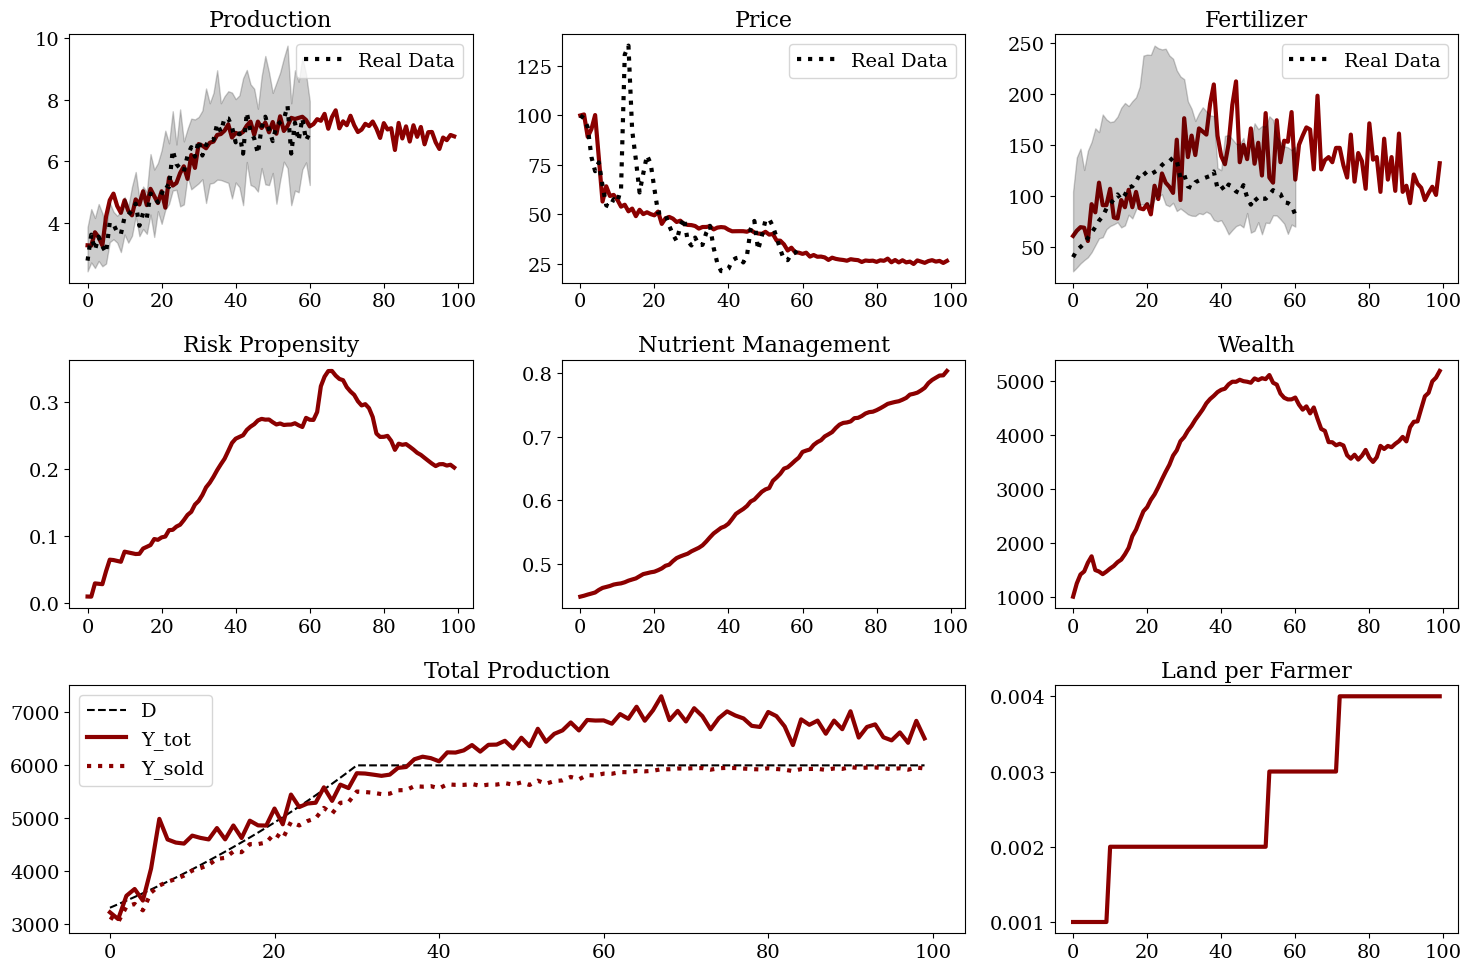

In [238]:

fig = plt.figure(figsize=(15,10))
gs = GridSpec(nrows=3, ncols=3)

c_matrix = generate_colormap_matrix('viridis', size)
color = 'darkred'

min_per = 50
max_per = 50

# Plotting demand and production
ax = fig.add_subplot(gs[0, 0])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), prod[active_farmer[:,i], i]/land_per_farmer[active_farmer[:,i], i], linestyle='-', c=color, lw = 0.5)
per_50 = np.nanpercentile(np.where(active_farmer == True, prod/land_per_farmer, np.nan), 50, axis=1)
per_5 = np.nanpercentile(np.where(active_farmer == True, prod/land_per_farmer, np.nan), min_per, axis=1)
per_95 = np.nanpercentile(np.where(active_farmer == True, prod/land_per_farmer, np.nan), max_per, axis=1)
ax.plot(range(per_50.size), per_50, c=color, ls='-', lw = 3, zorder = 0.5)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 0.5)
df = df_list[1]
df = df[['Year', 'Area', 'Value']]
df_pivot = df.pivot('Year', 'Area', values='Value')
per_50 = np.nanpercentile(df_pivot, 50, axis=1)/10000
per_5 = np.nanpercentile(df_pivot, 5, axis=1)/10000
per_95 = np.nanpercentile(df_pivot, 95, axis=1)/10000
year = df_pivot.index.to_numpy()
ax.plot(range(per_50.size), per_50, c='k', ls=':', label='Real Data', lw = 3)
ax.fill_between(range(per_50.size), per_5, per_95, color='k', alpha=0.2)
ax.legend()
ax.set_title('Production')


# Plotting price and market price
ax = fig.add_subplot(gs[0, 1])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), price[active_farmer[:,i], i], linestyle='', marker = '.', c=c_matrix[i], lw = 3)
per_50 = np.nanpercentile(np.where(active_farmer == True, price, np.nan), 50, axis=1)
per_5 = np.nanpercentile(np.where(active_farmer == True, price, np.nan), min_per, axis=1)
per_95 = np.nanpercentile(np.where(active_farmer == True, price, np.nan), max_per, axis=1)
ax.plot(range(per_50.size), per_50/per_50[0]*100, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5/per_50[0]*100, per_95/per_50[0]*100, color=color, alpha=0.2, zorder = 1)
# ax.plot(range(num_steps), market_price, linestyle='--', color='k', lw = 3, zorder = 2)
df = df_list[-1]
ax.plot(range(df['Year'].size), df['Value']/df['Value'].iloc[0]*100, c = 'k', ls = ':', lw = 3, label='Real Data')
ax.legend()
ax.set_title('Price')


# Plotting fertilizer
ax = fig.add_subplot(gs[0, 2])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), F[active_farmer[:,i], i], label='F', linestyle='-', c=color, lw = 0.5,zorder = 0)
per_50 = np.nanpercentile(np.where(active_farmer == True, F, np.nan), 50, axis=1)
per_5 = np.nanpercentile(np.where(active_farmer == True, F, np.nan), min_per, axis=1)
per_95 = np.nanpercentile(np.where(active_farmer == True, F, np.nan), max_per, axis=1)
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
df = df_list[2]
df = df[['Year', 'Area', 'Value']]
df_pivot = df.pivot('Year', 'Area', values='Value')
per_50 = np.nanpercentile(df_pivot, 50, axis=1)
per_5 = np.nanpercentile(df_pivot, 5, axis=1)
per_95 = np.nanpercentile(df_pivot, 95, axis=1)
year = df_pivot.index.to_numpy()
ax.plot(range(per_50.size), per_50, c='k', ls=':', label='Real Data', lw = 3, zorder = 2)
ax.fill_between(range(per_50.size), per_5, per_95, color='k', alpha=0.2, zorder = 2)
ax.legend()
ax.set_title('Fertilizer')

ax = fig.add_subplot(gs[1, 0])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), Soil_health[active_farmer[:,i], i], label='F', linestyle='-', c=c_matrix[i], lw = 3)
per_50 = np.nanpercentile(np.where(active_farmer == True, risk_propensity, np.nan), 50, axis=1)
per_5 = np.nanpercentile(np.where(active_farmer == True, risk_propensity, np.nan), min_per, axis=1)
per_95 = np.nanpercentile(np.where(active_farmer == True, risk_propensity, np.nan), max_per, axis=1)
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
ax.set_title('Risk Propensity')

# Plotting profit and wealth
ax = fig.add_subplot(gs[1, 2])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), wealth[active_farmer[:,i], i], linestyle='-', c=c_matrix[i], lw = 3)
per_50 = np.nanpercentile(np.where(active_farmer == True, wealth, np.nan), 50, axis=1)
per_5 = np.nanpercentile(np.where(active_farmer == True, wealth, np.nan), min_per, axis=1)
per_95 = np.nanpercentile(np.where(active_farmer == True, wealth, np.nan), max_per, axis=1)
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
ax.set_title('Wealth')

# Plotting profit and wealth
ax = fig.add_subplot(gs[1, 1])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), MP[active_farmer[:,i], i], linestyle='-', marker = '', c=c_matrix[i], lw = 3)
per_50 = np.nanpercentile(np.where(active_farmer == True, MP, np.nan), 50, axis=1)
per_5 = np.nanpercentile(np.where(active_farmer == True, MP, np.nan), min_per, axis=1)
per_95 = np.nanpercentile(np.where(active_farmer == True, MP, np.nan), max_per, axis=1)
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
ax.set_title('Nutrient Management')

ax = fig.add_subplot(gs[2, :2])
ax.plot(range(num_steps), np.sum(demand, axis=1), linestyle='--', color='k', label ='D')
ax.plot(range(num_steps), np.sum(prod, axis=1), linestyle='-', c=color, lw = 3, label = 'Y_tot')
ax.plot(range(num_steps), np.sum(fraction_sold * prod, axis=1), linestyle=':', c=color, lw = 3, label='Y_sold')
ax.set_title('Total Production')
ax.legend()

ax = fig.add_subplot(gs[2, 2])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), land_per_farmer[active_farmer[:,i], i]/size, linestyle='-', color=c_matrix[i], lw = 3)
# ax.plot(range(num_steps), np.sum(farmers_entering, axis=1)/size, linestyle='-', color=c_matrix[-1], lw = 3)
per_50 = np.nanpercentile(np.where(active_farmer == True, land_per_farmer/size, np.nan), 50, axis=1)
per_5 = np.nanpercentile(np.where(active_farmer == True, land_per_farmer/size, np.nan), min_per, axis=1)
per_95 = np.nanpercentile(np.where(active_farmer == True, land_per_farmer/size, np.nan), max_per, axis=1)
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
ax.set_title('Land per Farmer')

Text(0.5, 1.0, 'Land per Farmer')

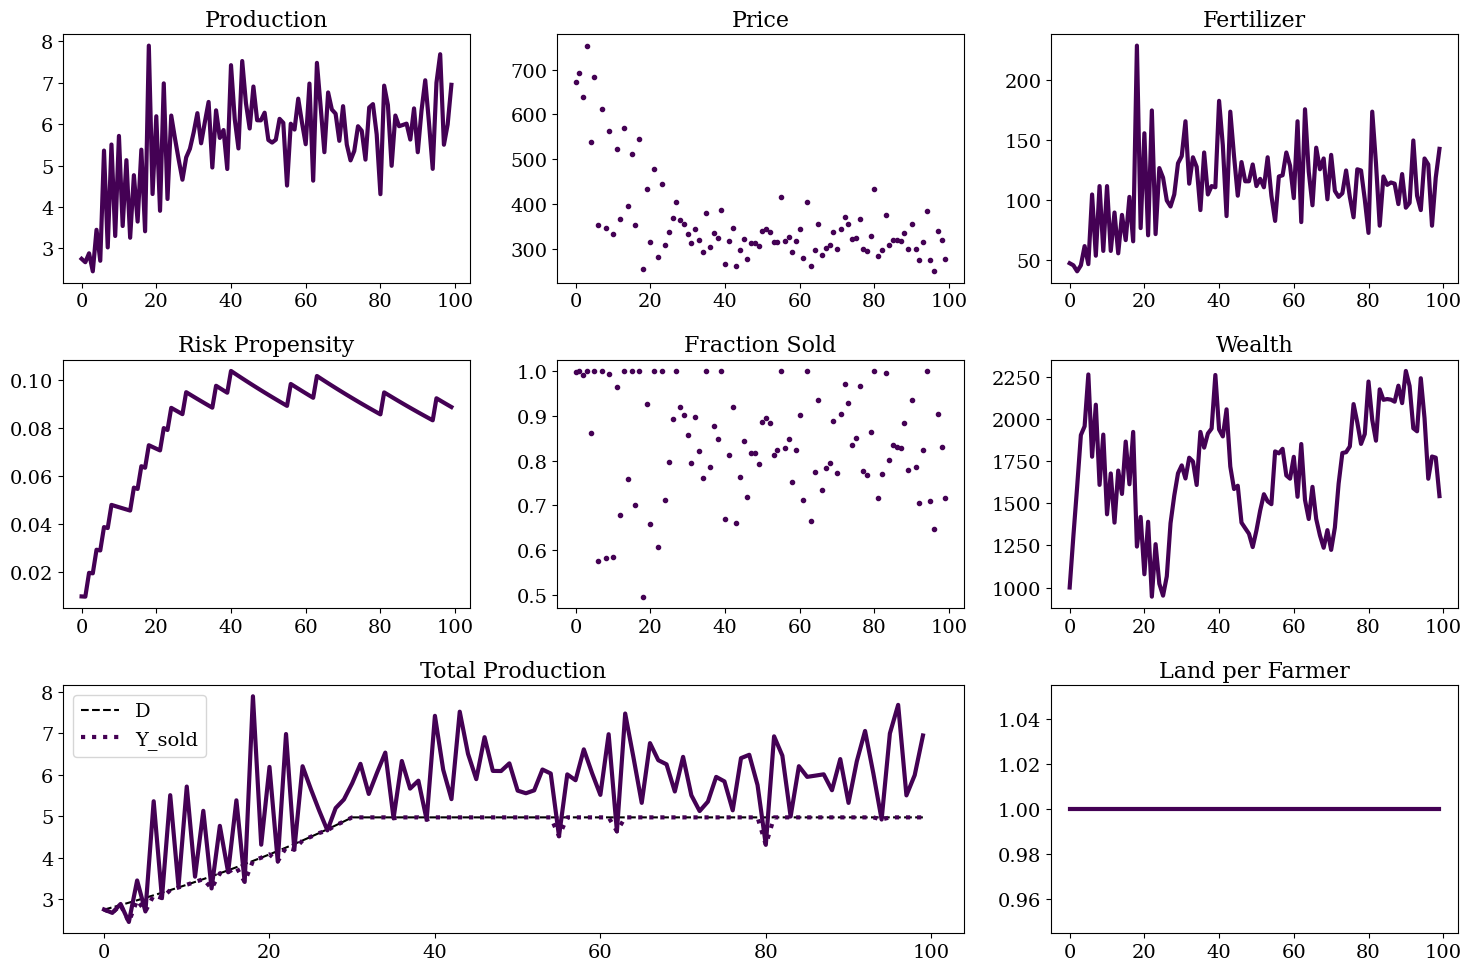

In [211]:

fig = plt.figure(figsize=(15,10))
gs = GridSpec(nrows=3, ncols=3)

c_matrix = generate_colormap_matrix('viridis', size)

# Plotting demand and production
ax = fig.add_subplot(gs[0, 0])
for i in range(size):
    ax.plot(range(num_steps), prod[:, i], linestyle='-', c=c_matrix[i], lw = 3)
ax.set_title('Production')

# Plotting price and market price
ax = fig.add_subplot(gs[0, 1])
for i in range(size):
    ax.plot(range(num_steps), price[:, i], linestyle='', marker = '.', c=c_matrix[i], lw = 3)
# ax.plot(range(num_steps), market_price, linestyle='--', color='k', lw = 3)
ax.set_title('Price')

# Plotting fertilizer
ax = fig.add_subplot(gs[0, 2])
for i in range(size):
    ax.plot(range(num_steps), F[:, i], label='F', linestyle='-', c=c_matrix[i], lw = 3)
ax.set_title('Fertilizer')

ax = fig.add_subplot(gs[1, 0])
for i in range(size):
    ax.plot(range(num_steps), risk_propensity[:, i], label='F', linestyle='-', c=c_matrix[i], lw = 3)
ax.set_title('Risk Propensity')

# Plotting profit and wealth
ax = fig.add_subplot(gs[1, 2])
for i in range(size):
    ax.plot(range(num_steps), wealth[:, i], linestyle='-', c=c_matrix[i], lw = 3)
ax.set_title('Wealth')

# Plotting profit and wealth
ax = fig.add_subplot(gs[1, 1])
for i in range(size):
    ax.plot(range(num_steps), fraction_sold[:, i], linestyle='', marker = '.', c=c_matrix[i], lw = 3)
ax.set_title('Fraction Sold')

ax = fig.add_subplot(gs[2, :2])
ax.plot(range(num_steps), np.sum(demand, axis=1), linestyle='--', color='k', label ='D')
ax.plot(range(num_steps), np.sum(prod, axis=1), linestyle='-', c=c_matrix[0], lw = 3)
ax.plot(range(num_steps), np.sum(fraction_sold * prod, axis=1), linestyle=':', c=c_matrix[-1], lw = 3, label='Y_sold')
ax.set_title('Total Production')
ax.legend()

ax = fig.add_subplot(gs[2, 2])
for i in range(size):
    ax.plot(range(num_steps), land_per_farmer[:, i]/size, linestyle='-', marker = '', c=c_matrix[i], lw = 3)
ax.set_title('Land per Farmer')

In [ ]:
def production(F, S, M):
    return ymax * (1 - np.exp(-1/Nr * (S + M * F))) * (1 + np.random.normal(0, 0.05, F.shape)) 

def F_optimal(previous_prod, S, M, p_M, fraction_sold, land_per_farmer, markup, risk_propensity, precision = 300):

    F_try = np.linspace(0, 300, precision)[:, np.newaxis]
    expected_production = land_per_farmer * production(F_try, S, M)
    expected_cost = (1 + markup) * land_per_farmer * ((p_F * F_try + p0) + p1)
    expected_revenues = p_M * expected_production 
    Profit_try = expected_revenues - expected_cost
    Risk_try = p_M * np.maximum(expected_production - fraction_sold * previous_prod, 0)
    Utility_try = Profit_try - (1 - risk_propensity) * Risk_try 
    max_P_indices = np.argmax(Utility_try, axis=0)  
    F_opt = F_try[max_P_indices, np.arange(F_try.shape[1])] 
    F_opt = F_opt 
    land_opt = land_per_farmer

    return F_opt, land_opt

ymax = 9
Nr = 60
p0 = 500
p1 = 1000
p_F = 0.8

# Number of time steps in the simulation
num_steps = 100
size = 1000

gamma = 0.02
r = 0.3
beta = 10
theta = 0
delta = 0.05
sigma = 0.0
demand_growth = 0.0


# Arrays to store values over the simulation
F_opt = np.zeros((num_steps, size))
risk_propensity = np.zeros((num_steps, size))
F = np.zeros((num_steps, size))
L = np.zeros((num_steps, size))
Soil_health = np.zeros((num_steps, size))
prod = np.zeros((num_steps, size))
markup = np.zeros((num_steps, size))
price = np.zeros((num_steps, size))
profit = np.zeros((num_steps, size))
revenues = np.zeros((num_steps, size))
costs = np.zeros((num_steps, size))
wealth = np.zeros((num_steps, size))
fraction_sold = np.zeros((num_steps, size))
fraction_sold_max_competition = np.zeros((num_steps, size))
land_per_farmer = np.zeros((num_steps, size))
active_farmer = np.zeros((num_steps, size), dtype=bool)
farmers_entering = np.zeros((num_steps, size), dtype=bool)
farmer_demand = np.zeros((num_steps, size))
MP = np.zeros((num_steps, size))
research_investment = np.zeros((num_steps, size))
demand = np.zeros((num_steps, size))
households_budget = np.zeros((num_steps, size))


# Initial values
land_per_farmer[0] = 1
F[0] = np.random.uniform(low = 30, high = 90, size = size)
Soil_health[0] = 0#np.random.uniform(low = 0, high = 15, size=size)
MP[0] = np.random.uniform(low = 0.4, high=0.5, size=size)
L[0] = land_per_farmer[0] 
risk_propensity[0] = 0.01#np.random.uniform(low = 0.4, high=0.5, size=size)
prod[0] = L[0] * production(F[0], Soil_health[0], MP[0])
markup[0] = 0.2
costs[0] = L[0] * (F[0] * p_F + p0) + p1
price[0] = (1 + markup[0]) * costs[0]/prod[0]
households_budget[0] = np.sum(L[0] * production(F[0], Soil_health[0], MP[0])*price[0])
demand[0] = households_budget[0] * price[0]**(1/(r-1))/np.sum(price[0]**(r/(r-1))) 
fraction_sold[0] = 1/prod[0] * np.minimum(demand[0], prod[0])

revenues[0] = price[0] * fraction_sold[0] * prod[0]
profit[0] =  revenues[0] - costs[0]
wealth[0] = 1000
active_farmer[0] = True
research_investment[0] = 0


# Simulation loop
for t in range(1, num_steps):

    active_farmer[t] = wealth[t-1] > theta
    land_per_farmer[t] = land_per_farmer[t-1]
    prod_share = np.zeros(size)
    if np.any(wealth[t-1] < theta):
        prob = active_farmer[t] * np.exp(beta * wealth[t-1] * active_farmer[t-1] / wealth[t-1, active_farmer[t-1]].mean()) / np.sum(active_farmer[t] *np.exp(beta * wealth[t-1] * active_farmer[t-1] / wealth[t-1, active_farmer[t-1]].mean()))
        auction_winner = np.random.choice(size, int(np.sum(land_per_farmer[t, wealth[t-1] * active_farmer[t-1] < theta])), p=prob, replace=True)
        indices, new_land = np.unique(auction_winner, return_counts=True)
        winners = np.zeros(size)
        winners[indices] = new_land
        land_per_farmer[t, winners > 0] += winners[winners > 0]
        land_per_farmer[t, wealth[t-1] * active_farmer[t-1] < theta] = 0  
        prod_share = winners * np.sum(fraction_sold[t-1] * prod[t-1] * (wealth[t-1] * active_farmer[t-1] < theta))/np.sum(winners)

    Soil_health[t] = Soil_health[t-1] * (1 - sigma * np.random.rand(size) * active_farmer[t]) 
    MP[t] = MP[t-1]
    risk_propensity[t, active_farmer[t]] = (1 - gamma) * risk_propensity[t-1, active_farmer[t]] + gamma * np.floor(fraction_sold[t-1, active_farmer[t]])
    

    F[t, active_farmer[t]], L[t, active_farmer[t]] = F_optimal(prod[t-1, active_farmer[t]] + prod_share[active_farmer[t]], Soil_health[t,active_farmer[t]], MP[t,active_farmer[t]],  price[t-1, active_farmer[t]],\
                                                                fraction_sold[t-1, active_farmer[t]], land_per_farmer[t, active_farmer[t]], \
                                                                markup[t-1, active_farmer[t]], risk_propensity[t, active_farmer[t]])
    
    markup[t, active_farmer[t]] = markup[t-1, active_farmer[t]] 
    prod[t, active_farmer[t]] = L[t, active_farmer[t]] * production(F[t, active_farmer[t]], Soil_health[t,active_farmer[t]], MP[t,active_farmer[t]])
    costs[t, active_farmer[t]] = L[t, active_farmer[t]] * (F[t, active_farmer[t]] * p_F + p0) + p1
    price[t, active_farmer[t]] = (1 + markup[t, active_farmer[t]]) * costs[t, active_farmer[t]]/prod[t, active_farmer[t]] 

    demand[t, active_farmer[t]] = np.sum(demand[t-1]) * (  1 + (t <= 30) * demand_growth) * price[t,active_farmer[t]]**(1/(r-1))/np.sum(price[t,active_farmer[t]]**(1/(r-1))) #households_budget[0] * price[t,active_farmer[t]]**(1/(r-1))/np.sum(price[t,active_farmer[t]]**(r/(r-1))) 
    fraction_sold[t, active_farmer[t]] = 1/prod[t, active_farmer[t]] * np.minimum(prod[t,active_farmer[t]], demand[t, active_farmer[t]])

    revenues[t, active_farmer[t]] = price[t, active_farmer[t]] * fraction_sold[t, active_farmer[t]] * prod[t, active_farmer[t]]
    profit[t, active_farmer[t]] =  revenues[t, active_farmer[t]] - costs[t, active_farmer[t]]
    
    research_investment[t, active_farmer[t]] = delta * wealth[t-1, active_farmer[t]]
    farms_innovating = np.random.rand(np.sum(active_farmer[t])) < 1 - np.exp(- 1/1000 * research_investment[t, active_farmer[t]])
    advancement = 0.15 * np.random.rand(np.sum(active_farmer[t])) * farms_innovating
    MP[t, active_farmer[t]] = MP[t, active_farmer[t]] + advancement * MP[t, active_farmer[t]]  * (1 - MP[t, active_farmer[t]])
    
    wealth[t, active_farmer[t]] = wealth[t-1, active_farmer[t]] + profit[t, active_farmer[t]] - delta * wealth[t, active_farmer[t]]

    wealth[t, np.invert(active_farmer[t])] = theta
    # print(wealth[t], F[t])